In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/AI projects/PlantVillage_Project'

/content/drive/MyDrive/AI projects/PlantVillage_Project


In [ ]:
#!unzip '/content/drive/My Drive/70909_150545_bundle_archive.zip'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.optimizers import Adam


Using TensorFlow backend.


In [ ]:
default_image_size = tuple((256,256))
width = 256
height = 256
depth = 3


### Function to convert images to array



In [ ]:
def convert_img_to_array(img_dir):
  try:
    image = cv2.imread(img_dir)
    if image is not None:
      image = cv2.resize(image, default_image_size)
      return img_to_array(image)
    else:
      return np.array([])
  except Exception as e:
    print(f'Error: {e}')
    return None

### Fetch images from directory



In [ ]:
directory_root = '../content/PlantVillage'
image_list, label_list = [], []
img_size_list = []
removed_dir = ['Tomato__Tomato_mosaic_virus', 'Potato___healthy']
print('[INFOR] loading images ...')
plant_disease_folder_list = os.listdir(directory_root)
for plant_disease_folder in plant_disease_folder_list:
  if plant_disease_folder in removed_dir:
    pass
  else:
    plant_disease_image_list = os.listdir(f'{directory_root}/{plant_disease_folder}')
    print(f'[INFOR] Processing {plant_disease_folder} ({len(plant_disease_image_list)})...')
    for image in plant_disease_image_list[:300]:
      image_directory = f'{directory_root}/{plant_disease_folder}/{image}'
      if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
        image_list.append(convert_img_to_array(image_directory))
        label_list.append(plant_disease_folder)
print('[INFOR] Image loading complete')

[INFOR] loading images ...
[INFOR] Processing Tomato_Bacterial_spot (2127)...
[INFOR] Processing Tomato__Target_Spot (1404)...
[INFOR] Processing Tomato_healthy (1591)...
[INFOR] Processing Tomato_Early_blight (1000)...
[INFOR] Processing Tomato_Leaf_Mold (952)...
[INFOR] Processing Tomato__Tomato_YellowLeaf__Curl_Virus (3209)...
[INFOR] Processing Tomato_Late_blight (1909)...
[INFOR] Processing Potato___Early_blight (1000)...
[INFOR] Processing Pepper__bell___Bacterial_spot (997)...
[INFOR] Processing Potato___Late_blight (1000)...
[INFOR] Processing Tomato_Spider_mites_Two_spotted_spider_mite (1676)...
[INFOR] Processing Pepper__bell___healthy (1478)...
[INFOR] Processing Tomato_Septoria_leaf_spot (1771)...
[INFOR] Image loading complete


###Get Size of Processed Image



In [ ]:
image_size = len(image_list)
image_size


3900

### Normalize arr

In [ ]:
np_image_list = np.array(image_list, dtype = np.float16)/255.0

### Split train/test


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np_image_list, label_list, test_size = 0.2, random_state = 42)
print(f'[INFOR] {len(X_train)} training inputs')
print(f'[INFOR] {len(y_train)} training labels')
print(f'[INFOR] {len(X_val)} validation inputs')
print(f'[INFOR] {len(y_val)} validation labels')

[INFOR] 3120 training inputs
[INFOR] 3120 training labels
[INFOR] 780 validation inputs
[INFOR] 780 validation labels


###Transform Image Labels uisng Scikit Learn's LabelBinarizer



In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_val = label_binarizer.transform(y_val)

In [ ]:
y_train.shape

(3120, 13)

###Print the classes



In [ ]:
label_binarizer.classes_

array(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato_healthy'], dtype='<U43')

###Data Augumentation

In [ ]:
aug = ImageDataGenerator(
  rotation_range=25,
  width_shift_range = 0.1,
  height_shift_range = 0.1,
  shear_range = 0.2,
  fill_mode = 'nearest',
  horizontal_flip = True
)

### Define model

In [ ]:
num_classes = len(label_binarizer.classes_)
model = Sequential()
input_shape = (height, width, depth)
chan_dim = -1
if K.image_data_format() == 'channels_first':
  input_shape = (depth, height, width)
  chan_dim = 1
model.add(Conv2D(32, (3,3), padding = 'same', input_shape = input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis = chan_dim))
model.add(MaxPooling2D(pool_size= (3,3)))
model.add(Dropout(rate = 0.25))
model.add(Conv2D(64, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis = chan_dim))
model.add(Conv2D(64, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis = chan_dim))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3,3), padding = 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis = chan_dim))
model.add(Conv2D(128, (3,3), padding= 'same'))
model.add(Activation('relu'))
model.add(BatchNormalization(axis = chan_dim))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)       

### Define Optim and Loss Function


In [ ]:
LR = 1e-3
num_epochs = 25
opt = Adam(learning_rate = LR,  decay = LR / num_epochs)
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
print("[INFO] training network...")

[INFO] training network...


### Training phase

In [ ]:
BS = 32
history = model.fit_generator(
    aug.flow(X_train, y_train, batch_size = BS),
    validation_data = (X_val, y_val),
    steps_per_epoch = len(X_train) // num_epochs,
    epochs = num_epochs,
    verbose = 1
    )


Epoch 1/25
124/124 [==============================] - 61s 489ms/step - loss: 0.1891 - accuracy: 0.9362 - val_loss: 0.7574 - val_accuracy: 0.8631
Epoch 2/25
124/124 [==============================] - 55s 442ms/step - loss: 0.1415 - accuracy: 0.9496 - val_loss: 0.8931 - val_accuracy: 0.8626
Epoch 3/25
124/124 [==============================] - 55s 441ms/step - loss: 0.1034 - accuracy: 0.9623 - val_loss: 0.9126 - val_accuracy: 0.8638
Epoch 4/25
124/124 [==============================] - 55s 444ms/step - loss: 0.0886 - accuracy: 0.9672 - val_loss: 0.3257 - val_accuracy: 0.9073
Epoch 5/25
124/124 [==============================] - 54s 438ms/step - loss: 0.0934 - accuracy: 0.9650 - val_loss: 0.8533 - val_accuracy: 0.8822
Epoch 6/25
124/124 [==============================] - 54s 436ms/step - loss: 0.0839 - accuracy: 0.9682 - val_loss: 0.1649 - val_accuracy: 0.9539
Epoch 7/25
124/124 [==============================] - 54s 439ms/step - loss: 0.0617 - accuracy: 0.9776 - val_loss: 0.1045 - val_ac

###Validation phase

In [ ]:
history.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

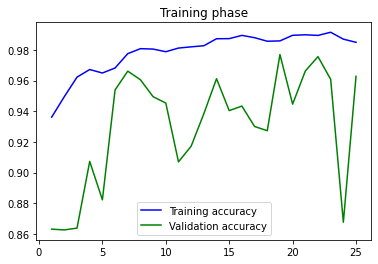

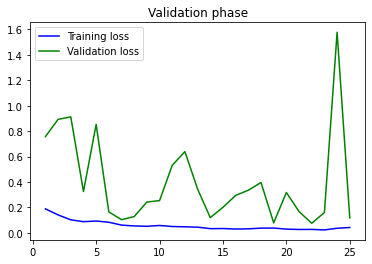

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'g', label = 'Validation accuracy')
plt.title('Training phase')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Validation phase')
plt.legend()
plt.show()



In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(X_val, y_val)
scores[1]

[INFO] Calculating model accuracy
780/780 [==============================] - 2s 2ms/step


0.9628205299377441

### Save model to disk

In [ ]:
# import pickle
# print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))

###Predict a new image

In [5]:
import tensorflow as tf


# Load model
cnn_model = tf.keras.models.load_model("crop.h5")

# Predict image
prob = cnn_model.predict(image)
prob

Saving background.jpg to background (1).jpg


ValueError: ignored

{'background.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x01\x01\x01\x01\x02\x01\x01\x01\x02\x02\x02\x02\x02\x04\x03\x02\x02\x02\x02\x05\x04\x04\x03\x04\x06\x05\x06\x06\x06\x05\x06\x06\x06\x07\t\x08\x06\x07\t\x07\x06\x06\x08\x0b\x08\t\n\n\n\n\n\x06\x08\x0b\x0c\x0b\n\x0c\t\n\n\n\xff\xdb\x00C\x01\x02\x02\x02\x02\x02\x02\x05\x03\x03\x05\n\x07\x06\x07\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\xff\xc2\x00\x11\x08\x01e\x02r\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1a\x00\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x08\xff\xc4\x00\x16\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\xff\xda\x00\x0c\x03\x01\x00\x02\x10\x03\x10\x00\x00\x01\xfd\xba]fT\x0b\x02\xc0\xb0,\n"Qs\xa2VJB\xd6J\xb9*\xc2\xc8-\x94\x8bIPD5\x10\xb5\x93R\xe4\xb5\x92\xd0\x85"h\x8a\x12\xe4\xd4\xa1%\n\x12\xc0\xb0YHRP\x96R\x10\xa44\x0